In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import warnings
import gc
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")
submit_df = pd.read_csv("./submit_sample.csv", header=None)


In [ ]:
# google colab
train_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/signate/train.csv")
test_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/signate/test.csv")
submit_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/signate/submit_sample.csv", header=None)

In [3]:
train_df.shape, test_df.shape, submit_df.shape

((27100, 18), (18050, 17), (18050, 2))

In [4]:
train_df.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,31,services,married,secondary,no,12294,yes,no,cellular,21,nov,101,3,498,0,other,0
1,1,29,entrepreneur,single,tertiary,no,43027,no,no,cellular,22,aug,158,2,702,0,unknown,1
2,2,35,management,married,tertiary,no,12252,yes,no,cellular,11,nov,351,1,826,0,failure,0
3,3,31,technician,married,secondary,no,99121,yes,yes,unknown,16,may,658,2,120,0,failure,0
4,4,48,unemployed,married,primary,no,42005,yes,no,telephone,3,apr,177,1,273,0,unknown,0


<BarContainer object of 42 artists>

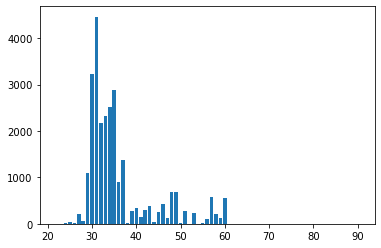

In [5]:
# それぞれの年齢におけるターゲットの数
plt.bar(train_df['age'].value_counts().sort_index().index, train_df['age'].value_counts().sort_index())

####  0  ~  9
#############################


####  10  ~  19
#############################


####  20  ~  29
#############################
22 1 1.0
24 8 1.0
25 35 5.0
26 10 3.0
27 222 13.0
28 66 7.0
29 1104 190.0
num_people is  1446


####  30  ~  39
#############################
30 3226 242.0
31 4464 202.0
32 2176 210.0
33 2318 135.0
34 2521 90.00000000000001
35 2888 123.00000000000001
36 907 31.0
37 1368 170.0
38 12 0.0
39 270 24.0
num_people is  20150


####  40  ~  49
#############################
40 333 28.999999999999996
41 153 5.0
42 307 46.0
43 385 22.0
44 39 5.0
45 252 28.0
46 435 53.0
47 115 5.0
48 675 54.0
49 683 76.0
num_people is  3377


####  50  ~  59
#############################
50 18 3.0
51 279 16.0
52 5 1.0
53 236 51.0
54 4 1.0
55 11 3.0
56 104 9.0
57 573 44.0
58 222 49.0
59 116 8.0
num_people is  1568


####  60  ~  69
#############################
60 546 157.0
63 6 0.0
num_people is  552


####  70  ~  79
#############################
73 1 0.0
77 1 0.0


####  80 

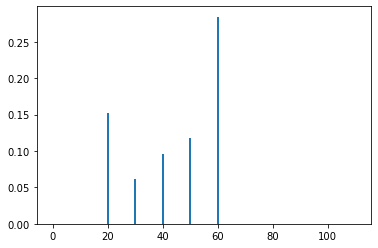

In [52]:
period = range(0, 120, 10)

# index : age (pandas Series obj)
#print(target_df["age"])
# the number of "y" in each colmun (numpy Array)
#print(np.array(target_df['y']) * np.array(train_df['age'].value_counts().sort_index()))
# list of age
#print(train_df['age'].value_counts().sort_index().index)

list_age = train_df['age'].value_counts().sort_index().index
target_df = train_df.groupby(['age'], as_index=False).mean()
sum_y = np.array(target_df['y']) * np.array(train_df['age'].value_counts().sort_index())


index = 0
num_people_list = np.zeros(len(period))
prob = np.zeros(len(period))
for i, lim_age in enumerate(period):
    num_people = 0
    print("#### ", lim_age, " ~ ", lim_age+10-1)
    print("#############################")
    for j, age in enumerate(list_age):
        if (age >= lim_age ) and (age < lim_age+10):
            print(age, np.array(train_df['age'].value_counts().sort_index())[j], sum_y[j])
            num_people += np.array(train_df['age'].value_counts().sort_index())[j]
            prob[i] += sum_y[j]
            index += 1
        else:
            if(lim_age+10-1 < age):
                break
    if (max(list_age) > age) and (num_people != 0):
        print("num_people is ", num_people)
        num_people_list[i] = num_people
        prob[i] /= num_people
    print("\n")

print("prob is \n", prob)
plt.bar(period, prob)
#plt.bar(period, num_people_list)
plt.show()

<BarContainer object of 11 artists>

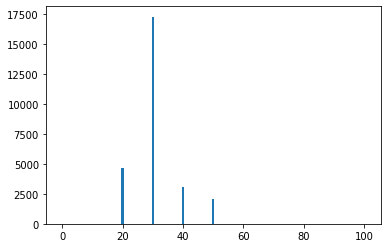

In [58]:
age_list = range(0, 120, 10)
age_ctgr = pd.cut(train_df['age'], bins=age_list)

plot_data = age_ctgr.value_counts().sort_index()
plt.bar(range(0, 110, 10), plot_data)

In [ ]:
all_df = pd.concat([train_df, test_df])
del train_df, test_df
gc.collect()

81

In [ ]:
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
for col in categorical_features:
    lbl = preprocessing.LabelEncoder()
    lbl.fit(all_df[col])
    lbl.transform(all_df[col])
    all_df[col] = lbl.transform(all_df[col])

In [ ]:
train_df = all_df[all_df['y']!=-999]
test_df = all_df[all_df['y']==-999]

In [ ]:
y_train = train_df['y']
X_train = train_df.drop(['y', 'id'], axis=1)
X_test = test_df.drop(['y', 'id'], axis=1)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=0, stratify=y_train)

In [ ]:
lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=categorical_features)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train, categorical_feature=categorical_features)

params = {
    "objective":"binary"
}

model = lgb.train(
    params, lgb_train,
    valid_sets = [lgb_train, lgb_eval],
    verbose_eval = 10,
    num_boost_round = 1000,
    early_stopping_rounds=10
)

y_pred = model.predict(X_test, num_iteration=model.best_iteration)

Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.209427	valid_1's binary_logloss: 0.219289
[20]	training's binary_logloss: 0.191038	valid_1's binary_logloss: 0.209227
[30]	training's binary_logloss: 0.178925	valid_1's binary_logloss: 0.204428
[40]	training's binary_logloss: 0.169569	valid_1's binary_logloss: 0.203095
[50]	training's binary_logloss: 0.161995	valid_1's binary_logloss: 0.20335
Early stopping, best iteration is:
[48]	training's binary_logloss: 0.163581	valid_1's binary_logloss: 0.203038


In [ ]:
y_pred

array([0.78074173, 0.07075874, 0.02624937, ..., 0.06533223, 0.0072316 ,
       0.13983576])

In [ ]:
submit_df[1] = y_pred

In [ ]:
submit_df.to_csv('./submit.csv', index=False, header=None)